In [135]:
import MDAnalysis as mda
from MDAnalysis.transformations import unwrap
import os
import numpy as np
import freud
import matplotlib.pyplot as plt

In [137]:
dir = "/home/gabriel/Dokumente/bachelor_thesis/dpd_simulation/lipid_self_assembly/"
top_file = os.path.join(dir, f"setup/lammps_{lipids}.data")
traj_file = os.path.join(dir, f"assembly/trajectories_{lipids}.lammpstrj")

Hier LAMMPS timestep eingeben

In [138]:
u = mda.Universe(top_file, format="DATA", atom_style = "id resid type charge x y z")
u.load_new(traj_file, format="LAMMPSDUMP", dt=0.01)

<Universe with 4608 atoms>

In [150]:
lipids = 128
steps = 600000
timescale = 91.2 #ps
timestep = u.trajectory.dt
frames = len(u.trajectory)
time_per_frame = steps/frames*timestep*(timescale/1000) #ns
print(time_per_frame)

1.8179401993355484


## Unwrap molecules, no bonds over box edge

In [139]:
transform = unwrap(u.atoms)
u.trajectory.add_transformations(transform)

## Contact number

In [140]:
def contact_number(universe):

    contact_number = np.zeros(len(universe.trajectory))
    lipid_res = u.residues[:lipids]

    for frame_id, frame in enumerate(universe.trajectory):

        box_dims = universe.dimensions[:3]
        coms = np.array([res.atoms.center_of_mass() for res in lipid_res])

        dist_matrix = coms[:,None,:] - coms[None,:,:]
        dist_matrix = dist_matrix - box_dims * np.round(dist_matrix/box_dims)

        dists = np.linalg.norm(dist_matrix, axis=2)
        np.fill_diagonal(dists, np.inf)

        box_dims_list = box_dims.tolist()
        index_double_occurence = [box_dims_list.count(x) for x in box_dims].index(2)

        assert index_double_occurence != None

        apl = box_dims[index_double_occurence]**2/(lipids/2)
        cutoff = 2*np.sqrt(apl/np.pi)
        
        neighbor_per_lipid = (dists <= cutoff).sum(axis=1)
        contact_number[frame_id] = np.mean(neighbor_per_lipid)

    return contact_number

In [141]:
self_assembly_contact_number = contact_number(u)

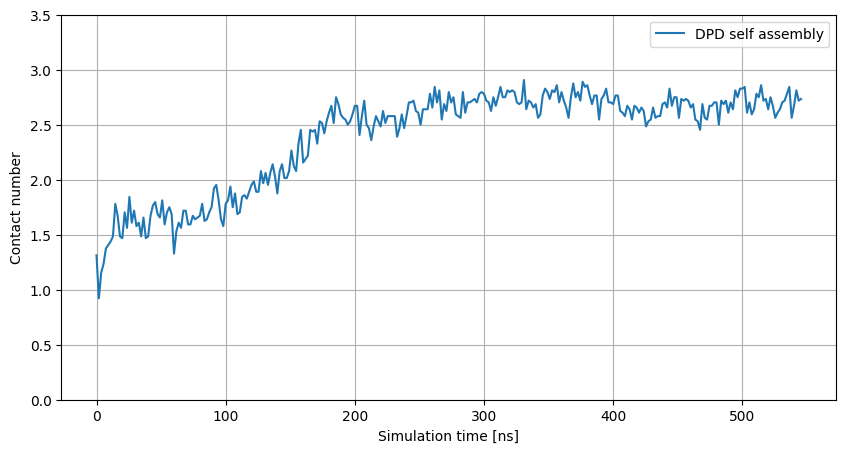

In [156]:
plt.figure(figsize=(10,5))

plt.plot(np.arange(len(self_assembly_contact_number))*time_per_frame,self_assembly_contact_number, label="DPD self assembly")
plt.xlabel("Simulation time [ns]")
plt.ylabel("Contact number")
plt.ylim((0,3.5))
plt.grid()
plt.legend()

## Nematic Order

In [157]:
nematic = freud.order.Nematic()

In [178]:
def neamtic_order(universe):

    s_values = np.zeros(len(universe.trajectory))
    directors = np.zeros((len(universe.trajectory), 3))

    lipid_res = u.residues[:128]

    for frame_id, frame in enumerate(universe.trajectory):


        orientations = np.zeros((len(lipid_res), 3))

        for mol_id, mol in enumerate(lipid_res):

            positions = mol.atoms.positions
            orientation_long = (positions[7] + positions[11])/2 - positions[0]
            orientations[mol_id] = orientation_long/np.linalg.norm(orientation_long)

        nematic.compute(orientations)

        s_values[frame_id] = nematic.order
        directors[frame_id] = nematic.director

    return s_values, directors

In [179]:
s_values, directors = neamtic_order(u)

Fill in correct values for frame flags

In [185]:
high_temp = 50
cool_down = 100
frame_axis = np.arange(0,frames)

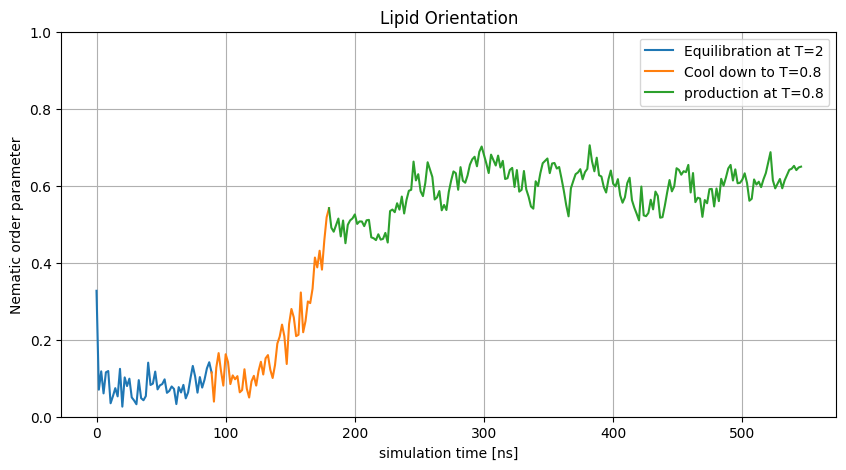

In [194]:
plt.figure(figsize=(10,5))

plt.plot(frame_axis[:high_temp]*time_per_frame,s_values[:high_temp], label="Equilibration at T=2")
plt.plot(frame_axis[high_temp-1:cool_down]*time_per_frame,s_values[high_temp-1:cool_down], label="Cool down to T=0.8")
plt.plot(frame_axis[cool_down-1:]*time_per_frame,s_values[cool_down-1:], label="production at T=0.8")

plt.ylim((0,1))
plt.xlabel("simulation time [ns]")
plt.ylabel("Nematic order parameter")
plt.title("Lipid Orientation")

plt.grid()
plt.legend()
plt.show()

## Density profile

In [195]:
def density_profile(universe):

    proj_heads = []
    proj_links = []
    proj_tails = []
    proj_terminal = []